# Fitness Low-Light Dataset - Demo Notebook

Demo 1: Filtering/querying the dataset based on specific brightness metrics.  
Demo 2: Visualizing labels for a specific video.

Note: this notebook relies on the `infinity-tools` python module, which can be installed following instructions [here](https://github.com/toinfinityai/infinity-tools#installation).

In [1]:
import os
import cv2
import json
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from IPython.display import clear_output
from infinity_tools.visionfit import vis
from infinity_tools.common.vis.videos import (
    parse_video_frames,
    stack_videos,
)

## Demo 1: Filter dataset by brightness metrics
We first show how you can filter the dataset based on the specific brightness metrics provided in the dataset annotations.

In [2]:
# specify location of the unzipped exercise folder
exercise_folder = "PATH_TO_SINGLE_EXERCISE_DATA_FOLDER"

In [3]:
# iterate over annotation jsons for each video and extract labels
json_paths = sorted(glob.glob(os.path.join(exercise_folder, "*_labels.json")))
metadata = []
for json_path in json_paths:
    coco = COCO(json_path)
    for img_info in coco.imgs.values():
        frame_info = {
            "video_number": os.path.basename(json_path).split("_")[0],
            "frame_number": img_info["frame_number"],
        }
        metadata.append({**frame_info, **img_info["metrics"]})
metadata_df = pd.DataFrame(metadata)
clear_output()
display(metadata_df.head())

,video_number,frame_number,mean_color_contrast,mean_brightness_contrast,mean_image_brightness,mean_avatar_brightness,mean_avatar_halo_brightness,snr
0,00000,0,5.605075,3.773783,2.250596,2.701098,1.221088,0.738316
1,00000,1,5.504465,3.898733,2.252351,2.697101,1.217385,0.738138
2,00000,2,5.385463,3.742985,2.246380,2.660362,1.204206,0.737845
3,00000,3,5.547845,3.621475,2.245710,2.617310,1.220770,0.737850
4,00000,4,5.322180,3.754948,2.245430,2.660334,1.208576,0.737714


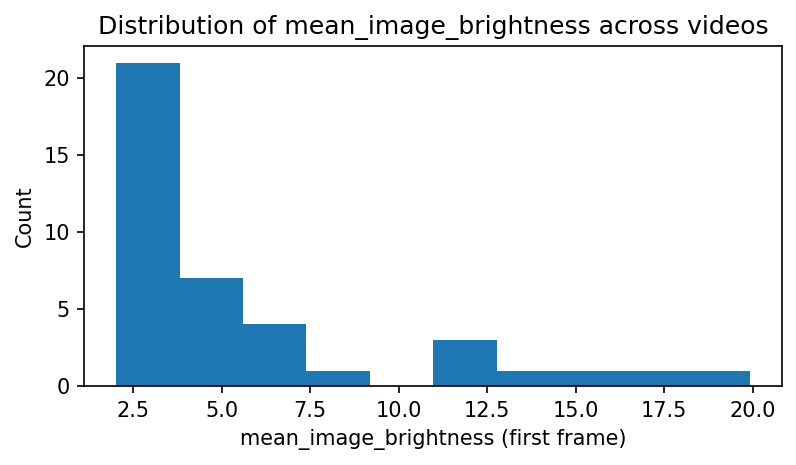

In [4]:
num_bins = 10
metric_to_plot = "mean_image_brightness"
fig, ax = plt.subplots(figsize=(6,3), dpi=150)
ax.hist(metadata_df.query("frame_number == 0")[metric_to_plot], bins=num_bins)
ax.set_title(f"Distribution of {metric_to_plot} across videos")
ax.set_xlabel(f"{metric_to_plot} (first frame)")
ax.set_ylabel("Count")
plt.show()

You can sort the dataframe based on your metric of choice. Here, we select a few random samples to visualize and sort them by `mean_image_brightness`.

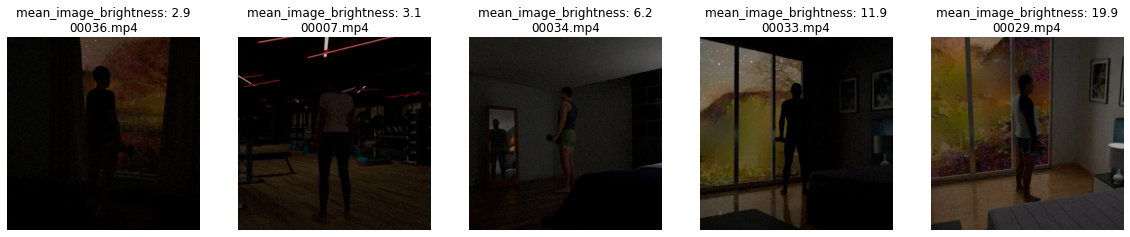

In [5]:
num_to_plot = 5
examples_to_plot = (
    metadata_df
    .query("frame_number == 0")
    .sample(n=num_to_plot, random_state=321)
    .sort_values(by=metric_to_plot, ascending=True)
)

fig,ax = plt.subplots(1, num_to_plot, figsize=(4*num_to_plot,4))
for i, (_, video_data) in enumerate(examples_to_plot.iterrows()):
    video_number = video_data['video_number']
    video_path = os.path.join(exercise_folder, f"{video_number}.mp4")
    vidcap = cv2.VideoCapture(video_path)
    success, img = vidcap.read()
    ax[i].imshow(img[:,:,::-1])
    ax[i].set_title(f"{metric_to_plot}: {video_data[metric_to_plot]:0.1f}\n{video_number}.mp4")
    ax[i].axis("off")
plt.show()

## Demo 2: Visualize Labels

In this next demo, we'll visualize a few of the different labels provided in Fitness Low-Light Dataset that can be used for training. We use the sample data provided in this repo.

In [6]:
def visualize_all_labels(video_rgb_path: str):

    output_directory = os.path.dirname(video_rgb_path)
    
    video_json_path = video_rgb_path.replace(".mp4", "_labels.json")
    zipped_video_path = video_rgb_path.replace(".mp4", "_segmentation.zip")
    job_json_path = video_rgb_path.replace(".mp4", "_params.json")
    job_params = json.load(open(job_json_path))["params"]

    video_rgb_extracted = video_rgb_path.replace(".mp4", "")
    os.makedirs(video_rgb_extracted, exist_ok=True)
    vis.unzip(zipped_video_path, video_rgb_extracted)

    imgs = parse_video_frames(video_rgb_path)
    fps = int(job_params["frame_rate"])
    rep_count = vis.parse_rep_count_from_json(video_json_path)
    coco = COCO(video_json_path)

    bounding_box_path = vis.create_bounding_boxes_video(os.path.join(output_directory, "bounding_box.mp4"), imgs, fps, coco)
    skeleton_path = vis.create_keypoint_connections_video(os.path.join(output_directory, "skeleton.mp4"), imgs, fps, coco)
    cuboids_path = vis.create_cuboids_video(os.path.join(output_directory, "cuboids.mp4"), imgs, fps, coco)
    _3D_path = vis.create_3D_keypoints_video(
        os.path.join(output_directory, "3D_keypoints.mp4"),
        fps,
        coco,
        150,
        imgs.shape[1],
        imgs.shape[2],
    )
    segmentation_path = vis.create_segmentation_video(
        os.path.join(output_directory, "segmentation.mp4"),
        video_rgb_extracted,
        fps,
        imgs.shape[1],
        imgs.shape[2],
    )


    row1_paths = [video_rgb_path, segmentation_path, bounding_box_path]
    label_videos_row_1 = stack_videos(row1_paths, axis=2, output_path=os.path.join(output_directory, "row1.mp4"))
    
    row2_paths = [cuboids_path, skeleton_path, _3D_path]
    label_videos_row_2 = stack_videos(row2_paths, axis=2, output_path=os.path.join(output_directory, "row2.mp4"))
    
    label_grid_path = stack_videos(
        paths=[label_videos_row_1, label_videos_row_2], 
        axis=1,
        output_path=os.path.join(output_directory, "merged_without_ts.mp4")
    )
    
    ts_path = vis.animate_time_series(
        os.path.join(output_directory, "timeseries.mp4"),
        rep_count,
        fps,
        width_in_pixels=imgs.shape[1] * 2,
        height_in_pixels=imgs.shape[1] * 2,
    )

    merged_video_path = stack_videos(
        paths=[label_grid_path, ts_path], 
        axis=2, 
        output_path=os.path.join(output_directory, "labels.mp4")
    )
    
    # cleanup and remove intermediate files
    remove_paths = row1_paths[1:] + row2_paths + [label_videos_row_1, label_videos_row_2, label_grid_path, ts_path]
    for e in remove_paths:
        os.remove(e)
    shutil.rmtree(video_rgb_extracted)
    clear_output()
    
    return merged_video_path

In [7]:
video_rgb_path = "./sample_data/00034.mp4"
labels_video_path = visualize_all_labels(video_rgb_path)
print(f"The resulting labels video can be viewed at: {labels_video_path}")

The resulting labels video can be viewed at: ./sample_data/labels.mp4
